# MEIRLOP Walkthrough: Score-based motif enrichment with covariates
This notebook will walk you through how to perform a score based motif enrichment analysis that accounts for experimentally derived covariates. To see the process in less detail (i.e. figure out what data formats go into and out of MEIRLOP) see the [quickstart guide](quickstart.ipynb). We will specifically recreate commands and output for the section "MEIRLOP identifies enriched TF binding motifs in DNase I Hypersensitive Sites" from the MEIRLOP manuscript.

This experiment was chosen because it can be performed with the highly available and organized public data from the ENCODE project, and because it showcases one of the most novel aspects of MEIRLOP: The ability to control for both sequence bias and experimentally derived covariates in motif enrichment analysis.

The following description of the experiment is adapted from the MEIRLOP manuscript:

Here, we use MEIRLOP to assign regulatory functions to TF motifs found enriched in DNase I Hypersensitive sites (DHS). Extensive chromatin profiling from ENCODE provides key information about the regulatory states at each DHS, although the levels of each chromatin modification are often correlated with the DNase hypersensitivity signal, which reflects the relative fraction of cells with open chromatin at that site in the population of cells ([ENCODE Project Consortium 2012](http://www.ncbi.nlm.nih.gov/pubmed/22955616), [Davis et al. 2018](http://www.ncbi.nlm.nih.gov/pubmed/29126249)).  To identify DHS that are associated with specific epigenetic profiles independent of hypersensitivity levels, we computed composite scores across 235220 DHS in K562 cells based on the log2 ratios of ChIP-seq coverage for the following scores: H3K27ac (active promoters and enhancers) over H3K27me3 (polycomb, repressive), reflecting active vs. repressed regulatory regions ([Creyghton et al. 2010](http://www.ncbi.nlm.nih.gov/pubmed/21106759)); And H3K4me3 (promoters) over H3K4me1 (enhancers), reflecting DHS with promoter vs. enhancer characteristics ([Sharifi-Zarchi et al. 2017](http://www.ncbi.nlm.nih.gov/pubmed/29233090)). Composite scores were derived from histone ChIP-seq coverage +/-500 bp from the peak centers. To account for correlation of these scores with DNase hypersensitivity signal, we incorporated DNase-seq coverage +/- 75bp from the peak centers as a covariate. We searched for motifs +/- 75bp from the peak centers.

## Prerequisites
Make sure you have the following packages and their dependencies installed:
* MEIRLOP (obviously)
* Wget
* Pandas
* Samtools
* Deeptools
* Seaborn
* Time

If you don't, you can run the following command to install. You will have to confirm the installed packages:

```
conda install -c bioconda -c conda-forge -c npdeloss meirlop wget pandas samtools deeptools seaborn time
```

## Prepare folders for temporary and archived files

In [1]:
%%bash
mkdir -p temporary_data
mkdir -p archived_data

## Show ENCODE Project data used
Here we reproduce supplementary table S4 from the MEIRLOP manuscript.

In [2]:
%%file archived_data/S4.csv
accession_id,source_url,dest_filename,lab_name
ENCSR000EOT,https://www.encodeproject.org/files/ENCFF156LGK/@@download/ENCFF156LGK.bam,dnase.bam,John Stamatoyannopoulos@UW
ENCSR000EOT,https://www.encodeproject.org/files/ENCFF821KDJ/@@download/ENCFF821KDJ.bed.gz,dnase.bed.gz,John Stamatoyannopoulos@UW
ENCSR000AKU,https://www.encodeproject.org/files/ENCFF633WWH/@@download/ENCFF633WWH.bam,h3k4me3_rep1.bam,Bradley Bernstein@Broad
ENCSR000AKU,https://www.encodeproject.org/files/ENCFF777LZD/@@download/ENCFF777LZD.bam,h3k4me3_rep2.bam,Bradley Bernstein@Broad
ENCSR000AKS,https://www.encodeproject.org/files/ENCFF778EZR/@@download/ENCFF778EZR.bam,h3k4me1_rep1.bam,Bradley Bernstein@Broad
ENCSR000AKS,https://www.encodeproject.org/files/ENCFF580LGK/@@download/ENCFF580LGK.bam,h3k4me1_rep2.bam,Bradley Bernstein@Broad
ENCSR000AKP,https://www.encodeproject.org/files/ENCFF301TVL/@@download/ENCFF301TVL.bam,h3k27ac_rep1.bam,Bradley Bernstein@Broad
ENCSR000AKP,https://www.encodeproject.org/files/ENCFF879BWC/@@download/ENCFF879BWC.bam,h3k27ac_rep2.bam,Bradley Bernstein@Broad
ENCSR000AKQ,https://www.encodeproject.org/files/ENCFF190OWE/@@download/ENCFF190OWE.bam,h3k27me3_rep1.bam,Bradley Bernstein@Broad
ENCSR000AKQ,https://www.encodeproject.org/files/ENCFF692KQZ/@@download/ENCFF692KQZ.bam,h3k27me3_rep2.bam,Bradley Bernstein@Broad
    

Writing archived_data/S4.csv


## Download and decompress DNase I Hypersensitive Sites from ENCODE
We download data describing the genomic coordinates of DNase I Hypersenstive sites(DHS) from ENCODE.

In [3]:
%%bash
wget -O temporary_data/dnase.bed.gz "https://www.encodeproject.org/files/ENCFF821KDJ/@@download/ENCFF821KDJ.bed.gz" &> temporary_data/dnase.bed.gz.log
zcat temporary_data/dnase.bed.gz > temporary_data/dnase.bed

## Center and widen DNase I Hypersensitive Sites
We center and widen each DHS, so that we can get sequence and DNase-seq coverage from +/- 75bp surrounding the center of the DHS, while obtaining histone ChIP-seq coverage from +/- 500bp surrounding the center of the DHS. This is important because histones are a 'wider range' signal.

In [4]:
import pandas as pd

In [5]:
# Set width for sequence and DNase-seq coverage
dhs_width = 150

# Set width for histone ChIP-seq coverage
dhs_histone_width = 1000

# Read DHS intercals
dnase_bed_df = pd.read_csv(
    'temporary_data/dnase.bed', 
    sep = '\t', 
    header = None, 
    names = (
        'chrom '
        'start '
        'end '
        'name '
        'score '
        'strand '
        'signal '
        'pval '
        'qval '
        'peak'
    ).split(' ')
)

# Center DHS
dnase_bed_df['original_start'] = dnase_bed_df['start']
dnase_bed_df['original_end'] = dnase_bed_df['end']
dnase_bed_df['center'] = dnase_bed_df['original_start'] + dnase_bed_df['peak']

# Rename DHS
dnase_bed_df['name'] = dnase_bed_df['chrom'].astype(str) + ':' + dnase_bed_df['center'].astype(str)
dnase_bed_df['score'] = dnase_bed_df['signal']
dnase_bed_df['dhs_signal'] = dnase_bed_df['score']

# These are unstanded so we stick to + strand
dnase_bed_df['strand'] = '+'

# Get interval for sequence and DNase-seq coverage
dnase_bed_df['start'] = dnase_bed_df['center'] - dhs_width // 2
dnase_bed_df['end'] = dnase_bed_df['center'] + dhs_width // 2

# Get interval for histone ChIP-seq coverage
dnase_bed_df['wide_start'] = dnase_bed_df['center'] - dhs_histone_width // 2
dnase_bed_df['wide_end'] = dnase_bed_df['center'] + dhs_histone_width // 2

# Sort and preview
dnase_bed_df = dnase_bed_df.sort_values(by = ['chrom', 'start']).reset_index(drop = True).copy()
dnase_bed_df.head()

,chrom,start,end,name,score,strand,signal,pval,qval,peak,original_start,original_end,center,dhs_signal,wide_start,wide_end
0,chr1,135042,135192,chr1:135117,54.0,+,54.0,-1,-1,75,135042,135192,135117,54.0,134617,135617
1,chr1,139311,139461,chr1:139386,41.0,+,41.0,-1,-1,75,139311,139461,139386,41.0,138886,139886
2,chr1,180751,180901,chr1:180826,70.0,+,70.0,-1,-1,75,180751,180901,180826,70.0,180326,181326
3,chr1,181415,181565,chr1:181490,480.0,+,480.0,-1,-1,75,181415,181565,181490,480.0,180990,181990
4,chr1,267990,268140,chr1:268065,490.0,+,490.0,-1,-1,75,267990,268140,268065,490.0,267565,268565


## Download softmasked version of genome from UCSC
We use the hg38 human genome reference.

In [6]:
%%bash
wget -O temporary_data/hg38.fa.gz https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz &> temporary_data/hg38.fa.gz.log
zcat temporary_data/hg38.fa.gz > temporary_data/hg38.fa

## Get sequence of DNase I Hypersensitive sites
You need sequence in order to perform a motif enrichment analysis on the DHS, after all!

We could use `bedtools getfasta` for this, but unfortunately the behavior of that tool has changed with recent versions (2.29.2). For now we'll use some of MEIRLOP's internal helper functions.
This also allows us to convert softmasked/indeterminate nucleotides to 'Ns'. This allows MEIRLOP to filter out sequences with too much repeat content.

In [7]:
from meirlop.io import read_fasta

In [8]:
# Load softmasked genome sequence, write helper functions
genome_fa_filepath = 'temporary_data/hg38.fa'
with open(genome_fa_filepath) as genome_fa_file:
    genome_fa_dict = read_fasta(genome_fa_file)
mask_softmasked_sequence = lambda sequence: ''.join([nuc if nuc in list('ACGT') else 'N' for nuc in sequence])
get_sequence = lambda chromosome, start, end: mask_softmasked_sequence(genome_fa_dict[chromosome][start:end])

# Name DHS and assign sequence
dnase_bed_df['peak_id'] = dnase_bed_df['name']
dnase_bed_df['sequence'] = dnase_bed_df['chrom start end'.split(' ')].apply(tuple, axis = 1).apply(lambda x: get_sequence(*x))

# Preview
dnase_bed_df.head()

,chrom,start,end,name,score,strand,signal,pval,qval,peak,original_start,original_end,center,dhs_signal,wide_start,wide_end,peak_id,sequence
0,chr1,135042,135192,chr1:135117,54.0,+,54.0,-1,-1,75,135042,135192,135117,54.0,134617,135617,chr1:135117,GCTGGGCCTAAAGAGGCCACTGGCAGGCAGGAGCTGGACCTGCCGA...
1,chr1,139311,139461,chr1:139386,41.0,+,41.0,-1,-1,75,139311,139461,139386,41.0,138886,139886,chr1:139386,AAGCTGGGCGTGAAGAATCTGCTGTGAGGCAGACGTTGGGACTGTA...
2,chr1,180751,180901,chr1:180826,70.0,+,70.0,-1,-1,75,180751,180901,180826,70.0,180326,181326,chr1:180826,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...
3,chr1,181415,181565,chr1:181490,480.0,+,480.0,-1,-1,75,181415,181565,181490,480.0,180990,181990,chr1:181490,CGTGGCGCAGGCGCAGAGAGGCGCGCCGTGCTGCCGCAGGCGCAGA...
4,chr1,267990,268140,chr1:268065,490.0,+,490.0,-1,-1,75,267990,268140,268065,490.0,267565,268565,chr1:268065,TTCTCTGTGCAGCACCAGGTGGCAGCAGAGGTCAGCAAGGCAAACC...


## Score DHS by histone ChIP-seq ratios
Now we get coverage for H3K27ac, H3K27me3, H3Kme1, and H3K4me3 +/- 500bp of the DHS center. We will use the log2 ratios of H3K27ac over H3K27me3 and H3Kme1 over H3K4me3 to score the DHS and determine motif enrichment along these scores.

### Download histone ChIP-seq data from ENCODE
This may take a while.

In [9]:
%%bash
# Download H3K4me3
wget -O temporary_data/h3k4me3_rep1.bam "https://www.encodeproject.org/files/ENCFF633WWH/@@download/ENCFF633WWH.bam" &> temporary_data/h3k4me3_rep1.bam.log &
wget -O temporary_data/h3k4me3_rep2.bam "https://www.encodeproject.org/files/ENCFF777LZD/@@download/ENCFF777LZD.bam" &> temporary_data/h3k4me3_rep2.bam.log &

# Download H3K4me1
wget -O temporary_data/h3k4me1_rep1.bam "https://www.encodeproject.org/files/ENCFF778EZR/@@download/ENCFF778EZR.bam" &> temporary_data/h3k4me1_rep1.bam.log &
wget -O temporary_data/h3k4me1_rep2.bam "https://www.encodeproject.org/files/ENCFF580LGK/@@download/ENCFF580LGK.bam" &> temporary_data/h3k4me1_rep2.bam.log &

# Download H3K27ac
wget -O temporary_data/h3k27ac_rep1.bam "https://www.encodeproject.org/files/ENCFF301TVL/@@download/ENCFF301TVL.bam" &> temporary_data/h3k27ac_rep1.bam.log &
wget -O temporary_data/h3k27ac_rep2.bam "https://www.encodeproject.org/files/ENCFF879BWC/@@download/ENCFF879BWC.bam" &> temporary_data/h3k27ac_rep2.bam.log &

# Download H3K27me3
wget -O temporary_data/h3k27me3_rep1.bam "https://www.encodeproject.org/files/ENCFF190OWE/@@download/ENCFF190OWE.bam" &> temporary_data/h3k27me3_rep1.bam.log &
wget -O temporary_data/h3k27me3_rep2.bam "https://www.encodeproject.org/files/ENCFF692KQZ/@@download/ENCFF692KQZ.bam" &> temporary_data/h3k27me3_rep2.bam.log &

wait

### Sort and index the histone ChIP-seq bam files
This may also take a while.

Change the number of threads (`num_threads`) to suit your computational environment.

In [10]:
%%bash
# Set number of threads
num_threads=45

# Sort and index bams for H3K4me3
samtools sort -@ "$num_threads" temporary_data/h3k4me3_rep1.bam -o temporary_data/h3k4me3_rep1.sorted.bam
samtools index temporary_data/h3k4me3_rep1.sorted.bam 
samtools sort -@ "$num_threads" temporary_data/h3k4me3_rep2.bam -o temporary_data/h3k4me3_rep2.sorted.bam
samtools index temporary_data/h3k4me3_rep2.sorted.bam 

# Sort and index bams for H3K4me1
samtools sort -@ "$num_threads" temporary_data/h3k4me1_rep1.bam -o temporary_data/h3k4me1_rep1.sorted.bam
samtools index temporary_data/h3k4me1_rep1.sorted.bam 
samtools sort -@ "$num_threads" temporary_data/h3k4me1_rep2.bam -o temporary_data/h3k4me1_rep2.sorted.bam
samtools index temporary_data/h3k4me1_rep2.sorted.bam 

# Sort and index bams for H3K27ac
samtools sort -@ "$num_threads" temporary_data/h3k27ac_rep1.bam -o temporary_data/h3k27ac_rep1.sorted.bam
samtools index temporary_data/h3k27ac_rep1.sorted.bam 
samtools sort -@ "$num_threads" temporary_data/h3k27ac_rep2.bam -o temporary_data/h3k27ac_rep2.sorted.bam
samtools index temporary_data/h3k27ac_rep2.sorted.bam 

# Sort and index bams for H3K27me3
samtools sort -@ "$num_threads" temporary_data/h3k27me3_rep1.bam -o temporary_data/h3k27me3_rep1.sorted.bam
samtools index temporary_data/h3k27me3_rep1.sorted.bam 
samtools sort -@ "$num_threads" temporary_data/h3k27me3_rep2.bam -o temporary_data/h3k27me3_rep2.sorted.bam
samtools index temporary_data/h3k27me3_rep2.sorted.bam 


[bam_sort_core] merging from 0 files and 45 in-memory blocks...
[bam_sort_core] merging from 0 files and 45 in-memory blocks...
[bam_sort_core] merging from 0 files and 45 in-memory blocks...
[bam_sort_core] merging from 0 files and 45 in-memory blocks...
[bam_sort_core] merging from 0 files and 45 in-memory blocks...
[bam_sort_core] merging from 0 files and 45 in-memory blocks...
[bam_sort_core] merging from 0 files and 45 in-memory blocks...
[bam_sort_core] merging from 0 files and 45 in-memory blocks...


### Make ratio bigwigs
We use Deeptools for this. This consists of two steps:
1. Within each replicate, make bigWig files of the log2 ratio of the histone ChIP-seq signal
2. Average the log2 ratios across replicates

Deeptools bamCompare accounts for sequencing depth differences.

In [11]:
%%bash

# Compare H3K4me3 and H3K4me1

## Replicate 1
bamCompare \
-b1 temporary_data/h3k4me3_rep1.sorted.bam \
-b2 temporary_data/h3k4me1_rep1.sorted.bam \
-o temporary_data/h3k4me3_over_h3k4me1_rep1.bw \
-p "max/2"  \
--effectiveGenomeSize 2913022398 \
--exactScaling \
--ignoreDuplicates \
&> temporary_data/h3k4me3_over_h3k4me1_rep1.bw.log &

## Replicate 2
bamCompare \
-b1 temporary_data/h3k4me3_rep2.sorted.bam \
-b2 temporary_data/h3k4me1_rep2.sorted.bam \
-o temporary_data/h3k4me3_over_h3k4me1_rep2.bw \
-p "max/2"  \
--effectiveGenomeSize 2913022398 \
--exactScaling \
--ignoreDuplicates \
&> temporary_data/h3k4me3_over_h3k4me1_rep2.bw.log &

# Compare H3K27ac and H3K27me3

## Replicate 1
bamCompare \
-b1 temporary_data/h3k27ac_rep1.sorted.bam \
-b2 temporary_data/h3k27me3_rep1.sorted.bam \
-o temporary_data/h3k27ac_over_h3k27me3_rep1.bw \
-p "max/2"  \
--effectiveGenomeSize 2913022398 \
--exactScaling \
--ignoreDuplicates \
&> temporary_data/h3k27ac_over_h3k27me3_rep1.bw.log &

## Replicate 2
bamCompare \
-b1 temporary_data/h3k27ac_rep2.sorted.bam \
-b2 temporary_data/h3k27me3_rep2.sorted.bam \
-o temporary_data/h3k27ac_over_h3k27me3_rep2.bw \
-p "max/2"  \
--effectiveGenomeSize 2913022398 \
--exactScaling \
--ignoreDuplicates \
&> temporary_data/h3k27ac_over_h3k27me3_rep2.bw.log &

wait

# Average log2 ratio of H3K4me3 over H3K4me1
bigwigCompare \
-b1 temporary_data/h3k4me3_over_h3k4me1_rep1.bw \
-b2 temporary_data/h3k4me3_over_h3k4me1_rep2.bw \
-o temporary_data/h3k4me3_over_h3k4me1_mean.bw \
-p "max/2"  \
--operation mean \
&> temporary_data/h3k4me3_over_h3k4me1_mean.bw.log &

# Average log2 ratio of H3K27ac over H3K27me3
bigwigCompare \
-b1 temporary_data/h3k27ac_over_h3k27me3_rep1.bw \
-b2 temporary_data/h3k27ac_over_h3k27me3_rep2.bw \
-o temporary_data/h3k27ac_over_h3k27me3_mean.bw \
-p "max/2"  \
--operation mean \
&> temporary_data/h3k27ac_over_h3k27me3_mean.bw.log &

wait

### Export the BED file containing the wide DHS intervals for histone

In [13]:
dhs_wide_filename = 'temporary_data/dhs_wide.bed'
dnase_bed_df[[
    'chrom', 
    'wide_start', 
    'wide_end', 
    'name', 
    'score', 
    'strand'
]].to_csv(
    dhs_wide_filename, 
    sep = '\t', 
    index = False, 
    header = None
)

### Score the BED file using the histone ratio bigWigs

In [14]:
%%bash
multiBigwigSummary BED-file \
--bwfiles \
temporary_data/h3k4me3_over_h3k4me1_mean.bw \
temporary_data/h3k27ac_over_h3k27me3_mean.bw \
--BED temporary_data/dhs_wide.bed \
--labels h3k4me3_over_h3k4me1 h3k27ac_over_h3k27me3 \
-out temporary_data/dhs_histone_scores.npz \
--outRawCounts temporary_data/dhs_histone_scores.txt \
-p max


Number of bins found: 235220


### Load the histone ratio scores

In [15]:
dhs_histone_scores_df = pd.read_csv(
    'temporary_data/dhs_histone_scores.txt', 
    sep = '\t', 
    comment = '#', 
    names = (
        'chrom '
        'wide_start '
        'wide_end '
        'h3k4me3_over_h3k4me1_mean '
        'h3k27ac_over_h3k27me3_mean'
    ).split(' ')
).fillna(0.0)
print(dhs_histone_scores_df.shape)
dhs_histone_scores_df.head()

(235220, 5)


,chrom,wide_start,wide_end,h3k4me3_over_h3k4me1_mean,h3k27ac_over_h3k27me3_mean
0,chrX,55426710,55427710,0.015336,-0.074066
1,chrX,55449970,55450970,-0.033253,-0.091628
2,chrX,55451610,55452610,1.611704,0.848003
3,chrX,55452190,55453190,1.761909,0.642169
4,chrX,55452430,55453430,1.577257,0.352656


### Merge the histone ratios with the previous DHS data

In [16]:
dnase_bed_df = dnase_bed_df.merge(dhs_histone_scores_df)
dnase_bed_df.head()

,chrom,start,end,name,score,strand,signal,pval,qval,peak,original_start,original_end,center,dhs_signal,wide_start,wide_end,peak_id,sequence,h3k4me3_over_h3k4me1_mean,h3k27ac_over_h3k27me3_mean
0,chr1,135042,135192,chr1:135117,54.0,+,54.0,-1,-1,75,135042,135192,135117,54.0,134617,135617,chr1:135117,GCTGGGCCTAAAGAGGCCACTGGCAGGCAGGAGCTGGACCTGCCGA...,-0.042544,0.045404
1,chr1,139311,139461,chr1:139386,41.0,+,41.0,-1,-1,75,139311,139461,139386,41.0,138886,139886,chr1:139386,AAGCTGGGCGTGAAGAATCTGCTGTGAGGCAGACGTTGGGACTGTA...,0.142488,0.142992
2,chr1,180751,180901,chr1:180826,70.0,+,70.0,-1,-1,75,180751,180901,180826,70.0,180326,181326,chr1:180826,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,0.000000,0.000000
3,chr1,181415,181565,chr1:181490,480.0,+,480.0,-1,-1,75,181415,181565,181490,480.0,180990,181990,chr1:181490,CGTGGCGCAGGCGCAGAGAGGCGCGCCGTGCTGCCGCAGGCGCAGA...,0.019169,0.000000
4,chr1,267990,268140,chr1:268065,490.0,+,490.0,-1,-1,75,267990,268140,268065,490.0,267565,268565,chr1:268065,TTCTCTGTGCAGCACCAGGTGGCAGCAGAGGTCAGCAAGGCAAACC...,-0.071272,0.022702


## Score DHS by DNase-seq coverage
Now we get the DNase-seq coverage directly over the interval of the extracted genomic sequence. We will use this value as a covariate.

### Download DNase-seq bam from ENCODE
This may take a while.

In [17]:
%%bash
wget -O temporary_data/dnase.bam "https://www.encodeproject.org/files/ENCFF156LGK/@@download/ENCFF156LGK.bam" &> temporary_data/dnase.bam.log

### Sort and index the DNase-seq bam
This may take a while. 

Change the number of threads (`num_threads`) to suit your computational environment.

In [18]:
%%bash
# Set number of threads
num_threads=45

samtools sort -@ "$num_threads" temporary_data/dnase.bam -o temporary_data/dnase.sorted.bam
samtools index temporary_data/dnase.sorted.bam 

[bam_sort_core] merging from 90 files and 45 in-memory blocks...


### Make DNase-seq bigWig

In [19]:
%%bash
bamCoverage \
-b temporary_data/dnase.sorted.bam \
-o temporary_data/dnase.bw \
-p "max/2" \
--effectiveGenomeSize 2913022398 \
--exactScaling \
--ignoreDuplicates \
&> temporary_data/dnase.bw.log

### Export the BED file containing the DHS intervals

In [21]:
dhs_filename = 'temporary_data/dhs.bed'
dnase_bed_df[[
    'chrom', 
    'start', 
    'end', 
    'name', 
    'score', 
    'strand'
]].to_csv(
    dhs_filename, 
    sep = '\t', 
    index = False, 
    header = None
)

### Score the BED file using the DNase-seq bigWig

In [22]:
%%bash
multiBigwigSummary BED-file \
--bwfiles temporary_data/dnase.bw \
--BED temporary_data/dhs.bed \
--labels dnase \
-out temporary_data/dhs_dnase_score.npz \
--outRawCounts temporary_data/dhs_dnase_score.txt \
-p max


Number of bins found: 235220


### Load the DNase-seq coverage scores

In [23]:
dhs_dnase_score_df = pd.read_csv(
    'temporary_data/dhs_dnase_score.txt', 
    sep = '\t', 
    comment = '#', 
    names = 'chrom start end dnase'.split(' ')
).fillna(0.0)
print(dhs_dnase_score_df.shape)
dhs_dnase_score_df.head()

(235220, 4)


,chrom,start,end,dnase
0,chr10,55426410,55426560,10.466667
1,chr10,55501095,55501245,26.900000
2,chr10,55550395,55550545,15.433333
3,chr10,55629815,55629965,16.433333
4,chr10,55631335,55631485,24.266667


### Merge the DNase-seq coverage with the previous DHS data

In [25]:
dnase_bed_df = dnase_bed_df.merge(dhs_dnase_score_df)
print(dnase_bed_df.shape)
dnase_bed_df.head()

(235220, 21)


,chrom,start,end,name,score,strand,signal,pval,qval,peak,...,original_end,center,dhs_signal,wide_start,wide_end,peak_id,sequence,h3k4me3_over_h3k4me1_mean,h3k27ac_over_h3k27me3_mean,dnase
0,chr1,135042,135192,chr1:135117,54.0,+,54.0,-1,-1,75,...,135192,135117,54.0,134617,135617,chr1:135117,GCTGGGCCTAAAGAGGCCACTGGCAGGCAGGAGCTGGACCTGCCGA...,-0.042544,0.045404,17.693333
1,chr1,139311,139461,chr1:139386,41.0,+,41.0,-1,-1,75,...,139461,139386,41.0,138886,139886,chr1:139386,AAGCTGGGCGTGAAGAATCTGCTGTGAGGCAGACGTTGGGACTGTA...,0.142488,0.142992,18.773333
2,chr1,180751,180901,chr1:180826,70.0,+,70.0,-1,-1,75,...,180901,180826,70.0,180326,181326,chr1:180826,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,0.000000,0.000000,32.893333
3,chr1,181415,181565,chr1:181490,480.0,+,480.0,-1,-1,75,...,181565,181490,480.0,180990,181990,chr1:181490,CGTGGCGCAGGCGCAGAGAGGCGCGCCGTGCTGCCGCAGGCGCAGA...,0.019169,0.000000,203.233333
4,chr1,267990,268140,chr1:268065,490.0,+,490.0,-1,-1,75,...,268140,268065,490.0,267565,268565,chr1:268065,TTCTCTGTGCAGCACCAGGTGGCAGCAGAGGTCAGCAAGGCAAACC...,-0.071272,0.022702,208.733333


## Write the scored FASTA files
Now we get to what MEIRLOP needs: Scored FASTA files! For each histone log2 ratio, we output a scored FASTA file in the AME style. That's like a normal FASTA file, but the sequence header has a space separating the sequence name and the sequence score, which in this case, is the histone log2 ratio. In addition, sequence names must be unique. See the `head` output below for examples.

In [26]:
# Histone ratio names
histone_ratios = [
    'h3k4me3_over_h3k4me1_mean', 
    'h3k27ac_over_h3k27me3_mean'
]

# Helper function to create a scored FASTA entry
get_scored_fa_entry = lambda peak_id, score, sequence: f'>{peak_id} {score}\n{sequence}'

# Write both histone ratios into scored FASTA files
for histone_ratio in histone_ratios:
    scored_fasta_filename = f'archived_data/dhs.{histone_ratio}.scored.fa'
    print(scored_fasta_filename)
    with open(scored_fasta_filename, 'w') as scored_fasta_file:
        scored_fasta_file.write(
            '\n'.join(
                list(
                    dnase_bed_df[
                        f'peak_id {histone_ratio} sequence'.split(' ')
                    ]
                    .apply(tuple, axis = 1)
                    .apply(lambda x: get_scored_fa_entry(*x))
                )
            ) + '\n'
        )
    ! wc -l {scored_fasta_filename}
    ! head {scored_fasta_filename}

archived_data/dhs.h3k4me3_over_h3k4me1_mean.scored.fa
470440 archived_data/dhs.h3k4me3_over_h3k4me1_mean.scored.fa
>chr1:135117 -0.042543599009513856
GCTGGGCCTAAAGAGGCCACTGGCAGGCAGGAGCTGGACCTGCCGAAGTGGCCGAAAGGCAGGAGCTTTGGACTGGGGAGGCCGCAGTGAGGCGAGAGCTAGCTGGGCGTGGAGAGTCCGCTGTGAGGCCGAGGCCGAGGCTGGGCCCGT
>chr1:139386 0.1424880027770996
AAGCTGGGCGTGAAGAATCTGCTGTGAGGCAGACGTTGGGACTGTAGAGGCTGACGGGAGGCAGAGGCTGGGCCTGGAGGGGCCACCAAGATGCAGGAGCTGGGCCTGGAGAGGCTGCAAAGAAGCATGAGCTGGGCCTGGTGAGGTCAA
>chr1:180826 0.0
TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACAACCCTAACCCTAACCCTAACAACCCTAACCCTAACCCTAACCCTAACCCTAAC
>chr1:181490 0.019169449806213382
CGTGGCGCAGGCGCAGAGAGGCGCGCCGTGCTGCCGCAGGCGCAGAGACACATGCTAGCGCGTCCAGGGGGTGGAGGCGTGGCGCAGGCGCAGAGACGCACGCCTACGGGCGGGGTTGGGGGGGGCGTGTGTTACAGGAGCAAAGTCGCA
>chr1:268065 -0.07127180099487304
TTCTCTGTGCAGCACCAGGTGGCAGCAGAGGTCAGCAAGGCAAACCCGAGCCCGGGGATGCGGAGTGGGGGCAGCTACGTCCTCTCTTGAGCTACAGCAGATTCACTCTGTTCTGTTTCATTGTTGTTT

## Write the covariate file
MEIRLOP also takes a covariate file that it can use alongside the ones it calculates for sequence bias. This is simply a tab-separated values file with two (or more) labeled columns, in order:
1. The name of the sequence (`peak_id`)
2. Any additional covariate values

In this case, the covariates file contains the DNase-seq coverage score. This way MEIRLOP can control for differences between DHS with high or low accessibility.

In [28]:
covariates_filename = 'archived_data/dhs.dnase.covariates.tsv'
(dnase_bed_df[[
    'peak_id', 
    'dnase'
]].fillna(0.0)
.to_csv(
    covariates_filename, 
    sep = '\t', 
    index = False
))
print(covariates_filename)
! wc -l covariates_filename
! head {covariates_filename}

archived_data/dhs.dnase.covariates.tsv
wc: covariates_filename: No such file or directory
peak_id	dnase
chr1:135117	17.693333333333328
chr1:139386	18.773333333333333
chr1:180826	32.89333333333333
chr1:181490	203.2333333333333
chr1:268065	208.7333333333333
chr1:268500	8.666666666666666
chr1:608551	4.733333333333333
chr1:629230	125.7
chr1:629554	81.61333333333333


## Download the JASPAR motifs file
MEIRLOP finds the enrichment of known motifs (for now), so we must supply it a motif matrix file in JASPAR format.

Here we use the JASPAR 2018 non-redundant vertebrate transcription factor motif database, which consists of 579 motifs. This database was selected to limit redundancy between different versions of what are essentially the same motif (i.e. avoid many motifs matching the same transcription factor), and to restrict the motifs tested to those relevant for analyzing human data.

Downloading requires that we spoof the user-agent through `wget`.

In [29]:
%%bash
wget -O temporary_data/JASPAR2018_CORE_vertebrates_non-redundant_pfms_jaspar.txt \
-r -l1 -U "Mozilla/5.0 (X11; Linux i686 (x86_64)) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.75 Safari/537.36" \
http://jaspar2018.genereg.net/download/CORE/JASPAR2018_CORE_vertebrates_non-redundant_pfms_jaspar.txt \
&> temporary_data/JASPAR2018_CORE_vertebrates_non-redundant_pfms_jaspar.txt.log

head temporary_data/JASPAR2018_CORE_vertebrates_non-redundant_pfms_jaspar.txt

>MA0004.1	Arnt
A  [     4     19      0      0      0      0 ]
C  [    16      0     20      0      0      0 ]
G  [     0      1      0     20      0     20 ]
T  [     0      0      0      0     20      0 ]
>MA0006.1	Ahr::Arnt
A  [     3      0      0      0      0      0 ]
C  [     8      0     23      0      0      0 ]
G  [     2     23      0     23      0     24 ]
T  [    11      1      1      1     24      0 ]


## Running MEIRLOP with custom covariates
And here's the part we've been working for: Actually running MEIRLOP with custom covariates!

Here we run MEIRLOP twice, once for each scored fasta file we generated, corresponding to the histone ratios we derived.

An explanation of our options and other components of the command line invocation:
* `num_threads=30`: The number of threads. We use 30 threads. Adjust to suit your computational environment
* `OMP_NUM_THREADS="$num_threads"`: Specify this or else statsmodels hogs all the cores for logistic regression (**Optional**, default: statsmodels hogs all cores).
* `$(which time) --verbose`: Track resource usage. (**Optional** but recommended)
* `meirlop`: You're running MEIRLOP. (**MANDATORY**)
* `--jobs "$num_threads"`: Enable multithreading on the number of threads specified (**Optional**, default: no multithreading).
* `--kmer 2`: Control for sequence bias, quantified through **di**nucleotide frequencies. (**Optional**, default: same behavior as described in this command)
* `--covariates archived_data/dhs.dnase.covariates.tsv`: Control for the experimental covariates in the specified file. (**Optional**, default: Don't use covariates other than sequence bias)
* `--pcount 0.001 --pval 0.001`: Set the pseudocount and p-value for the underlying MOODS motif scanner. (**Optional**, default: same behavior as described in this command)
    * In AME, the argument ‘--motif-pseudo’ is analogous to ‘--pcount’ in MEIRLOP, and defaults to 0.1. When comparing to AME, you may want to adjust these values.
* `--html`: Enable pretty HTML output (**Optional** but highly recommended). 
    * If you need prettier figures at the cost of a clunkier browser experience, you can also enable the `--svg` option, which doesn't pixelate motif logos when resized.
* `--scan`: Output data about where motifs were detected in the input sequences. Takes a while to write, but can come in handy (**Optional**, default: Don't output motif scan data).
* `--sortabs`: Sort by the absolute value of the enrichment coefficient. (**Optional**, default: Sort by motif enrichment coefficient, higher values first)
    * If you're interested in motifs enriched towards either extreme of a score, this option is for you.
    * Other packages like HOMER and AME assume a one-sided analysis, and would require two runs to get a picture of both extremes of the score.
* `--fa archived_data/dhs.h3k4me3_over_h3k4me1_mean.scored.fa`: Analyze our scored fasta file that we generated (Analysis of a scored fasta file is **MANDATORY**).
* `temporary_data/JASPAR2018_CORE_vertebrates_non-redundant_pfms_jaspar.txt` Use the JASPAR 2018 motif database we just downloaded (using a motif database is **MANDATORY**).
    * You can use other motif databases as long as they are in JASPAR format.
* `temporary_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop`: Output will be in `differential_tss.meirlop` (**MANDATORY**)...
* `&> temporary_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop.log`: ... with a similarly named log file (**Optional** but recommended).
* `mkdir -p archived_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop`: A few of these files are too big for Github, so we're going to copy the relevant ones here
* `cp temporary_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop/lr_results.* archived_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop/`
    * Copy over the main `lr_results.html` and `lr_results.tsv` files, which contain the logisitic regression results.

In [30]:
%%bash
# Specify number of threads
num_threads=30

# Analyze DHS scored by log2 ratio of H3K4me3 over H3K4me1
OMP_NUM_THREADS="$num_threads" \
$(which time) --verbose \
meirlop \
--jobs "$num_threads" \
--kmer 2 \
--covariates archived_data/dhs.dnase.covariates.tsv \
--pcount 0.001 --pval 0.001 \
--html \
--scan \
--sortabs \
--fa archived_data/dhs.h3k4me3_over_h3k4me1_mean.scored.fa \
temporary_data/JASPAR2018_CORE_vertebrates_non-redundant_pfms_jaspar.txt \
temporary_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop \
&> temporary_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop.log

mkdir -p archived_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop
cp temporary_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop/lr_results.* archived_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop/

# Analyze DHS scored by log2 ratio of H3K27ac over H3K27me3
OMP_NUM_THREADS="$num_threads" \
$(which time) --verbose \
meirlop \
--jobs "$num_threads" \
--kmer 2 \
--covariates archived_data/dhs.dnase.covariates.tsv \
--pcount 0.001 --pval 0.001 \
--html \
--scan \
--sortabs \
--fa archived_data/dhs.h3k27ac_over_h3k27me3_mean.scored.fa \
temporary_data/JASPAR2018_CORE_vertebrates_non-redundant_pfms_jaspar.txt \
temporary_data/h3k27ac_over_h3k27me3_mean.custom_covariate.meirlop \
&> temporary_data/h3k27ac_over_h3k27me3_mean.custom_covariate.meirlop.log

mkdir -p archived_data/h3k27ac_over_h3k27me3_mean.custom_covariate.meirlop
cp temporary_data/h3k27ac_over_h3k27me3_mean.custom_covariate.meirlop/lr_results.* archived_data/h3k27ac_over_h3k27me3_mean.custom_covariate.meirlop/


## Display MEIRLOP results
If you enabled the `--html` option when running MEIRLOP, you have access to an interactive display of the results in HTML, in the file `lr_results.html`. We can show this in a jupyter notebook using the `display` and `IFrame` functions. The HTML output is useful because it embeds the motif logos and has quality of life features including color-coded bar plots to visualize values, search capabilities, and the ability to sort along arbitrary columns.

The enrichment coefficient is in the column labeled `coef`. The corresponding p-value and adjusted p-value are available in the columns labeled `pval` and `padj` respectively. The percentage of peaks that had a motif is reflected in `percent_peaks`, with the raw number in `num_peaks`.

In [31]:
from IPython.display import display, IFrame

### Display MEIRLOP results for DHS scored by log2 ratio of H3K4me3 over H3K4me1

In [32]:
display(IFrame('archived_data/h3k4me3_over_h3k4me1_mean.custom_covariate.meirlop/lr_results.html', 1600, 1550))

### Display MEIRLOP results for DHS scored by log2 ratio of H3K27ac over H3K27me3

In [33]:
display(IFrame('archived_data/h3k27ac_over_h3k27me3_mean.custom_covariate.meirlop/lr_results.html', 1600, 1550))

## Recreating Figure 5 from the MEIRLOP manuscript
Here we recreate the two bar plots of the histone ratio motif enrichment results. These plot the top and bottom 10 significantly enrichmed motifs along each score.

### For each histone ratio, get the top and bottom 10 results

In [34]:
histone_pairs = [('h3k4me3', 'h3k4me1'), ('h3k27ac', 'h3k27me3')]

n_top = 10
read_tsv = lambda filepath: pd.read_csv(filepath, sep = '\t')

select_sig_by_ratio_str = {}
ratio_lr_results_df_by_ratio_str = {}
for histone_1, histone_2 in histone_pairs:
    # Retrieve the logistic regression results
    meirlop_outdir_suffix = '_mean.custom_covariate.meirlop'
    lr_results_suffix = f'{meirlop_outdir_suffix}/lr_results.tsv'
    ratio_str = f'{histone_1}_over_{histone_2}'
    
    ratio_lr_results_filepath = f'archived_data/{ratio_str}{lr_results_suffix}'
    ratio_lr_results_df = read_tsv(ratio_lr_results_filepath)
    ratio_lr_results_df_by_ratio_str[ratio_str] = ratio_lr_results_df
    
    # Get the significant results, filtered by the padj_sig column
    ratio_lr_results_sig_df = ratio_lr_results_df[ratio_lr_results_df['padj_sig'] == 1].copy()
    # Get the top significant motifs by enrichment coefficient
    top_sig = list(ratio_lr_results_sig_df[(ratio_lr_results_sig_df['coef']).rank() <= n_top]['motif_id'])
    # Get the bottom significant motifs by enrichment coefficient
    bottom_sig = list(ratio_lr_results_sig_df[(-ratio_lr_results_sig_df['coef']).rank() <= n_top]['motif_id'])
    # Combine the top and bottom significant motifs by enrichment coefficient
    select_sig = top_sig + bottom_sig
    select_sig_by_ratio_str[ratio_str] = select_sig


### Make the bar plots

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [36]:
# Lookup human-friendly names for our signals and ratios
histone_renames = {
    'h3k27ac_over_h3k27me3': 'H3K27ac ChIP-seq \n over H3K27me3 ChIP-seq',
    'h3k27ac': 'H3K27ac ChIP-seq',
    'h3k27me3': 'H3K27me3 ChIP-seq',
    'h3k4me3_over_h3k4me1': 'H3K4me3 ChIP-seq \n over H3K4me1 ChIP-seq',
    'h3k4me3': 'H3K4me3 ChIP-seq',
    'h3k4me1': 'H3K4me1 ChIP-seq'
}


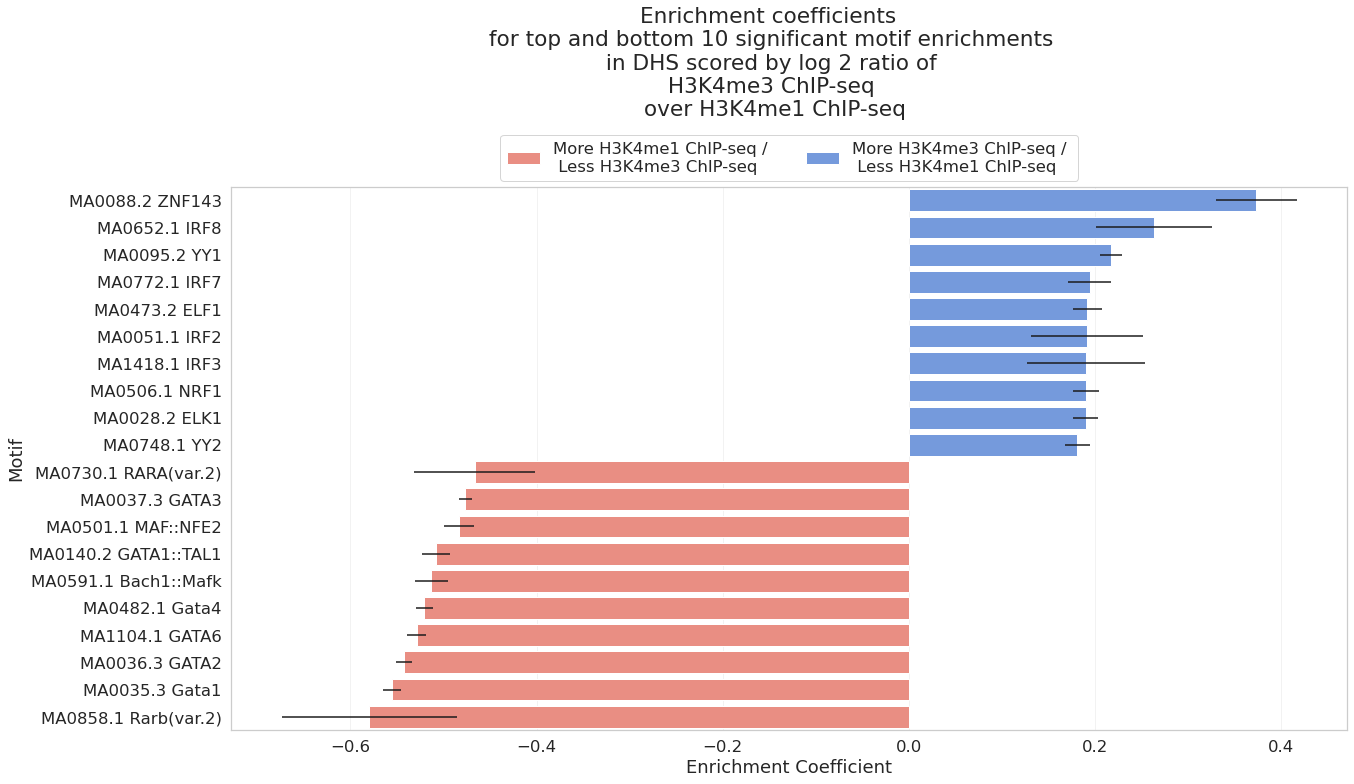

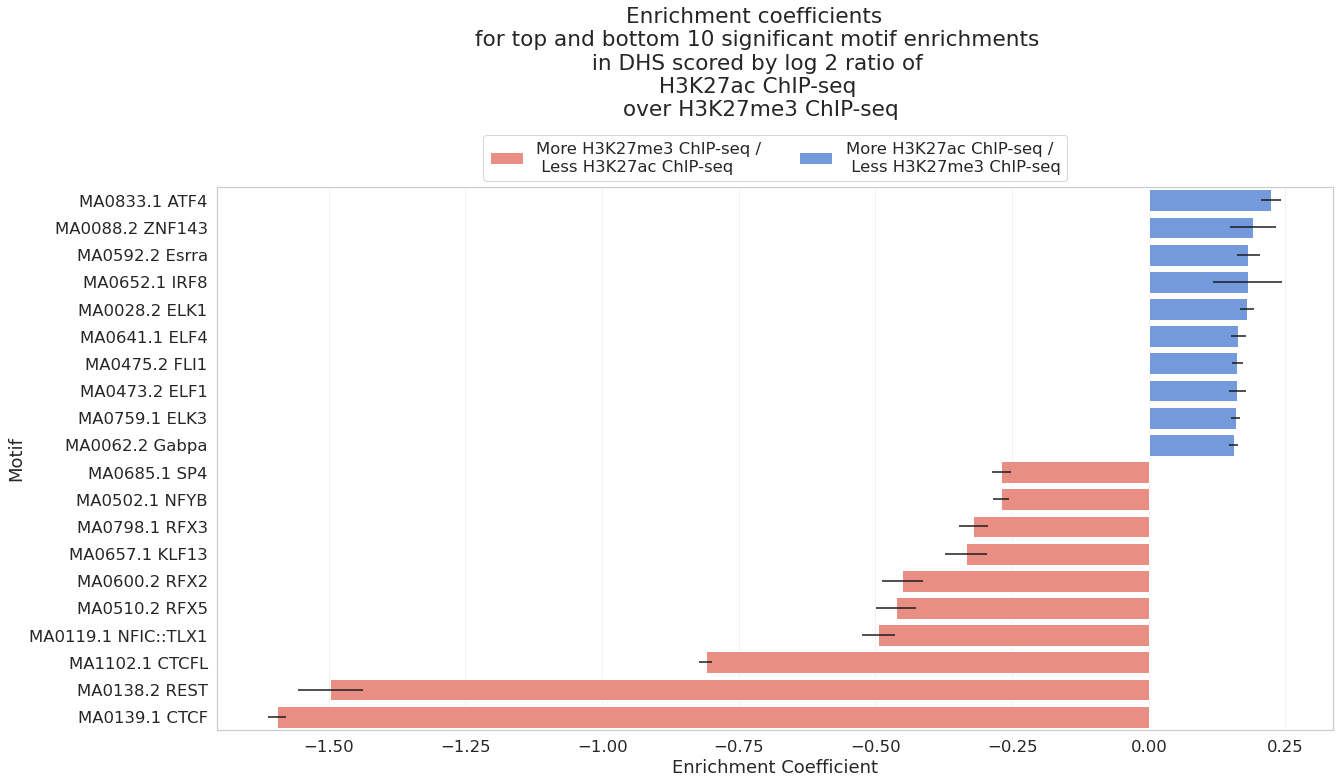

In [37]:
for histone_1, histone_2 in histone_pairs:
    # Retrieve the logistic regression results
    ratio_str = f'{histone_1}_over_{histone_2}'
    ratio_lr_results_df = ratio_lr_results_df_by_ratio_str[ratio_str]
    
    # Retrieve human-friendly names for our signals and ratios
    ratio_name = histone_renames[ratio_str]
    histone_1_name = histone_renames[histone_1]
    histone_2_name = histone_renames[histone_2]
    
    # Setup some plot aesthetics
    plt.rcParams['grid.alpha'] = 0.25
    plt.figure(figsize = (20, 10))
    sns.set(font_scale = 1.5)
    sns.set_style('whitegrid')
    
    # Get the top and bottom significant motifs by enrichment coefficient
    select_sig = select_sig_by_ratio_str[ratio_str]
    
    # Select just these top/bottom significant motifs, and their statistics
    ratio_lr_results_select_df = ratio_lr_results_df[ratio_lr_results_df['motif_id'].isin(select_sig)].copy()
    ratio_lr_results_select_df = ratio_lr_results_select_df.sort_values(by = 'coef', ascending = False)
    ratio_lr_results_select_df['Motif'] = ratio_lr_results_select_df['motif_id']
    ratio_lr_results_select_df['Enrichment Coefficient'] = ratio_lr_results_select_df['coef']
    
    # Extract the 95% confidence intercals
    coef_errs = (
        ratio_lr_results_select_df[
            [
                'ci_95_pct_lower', 
                'ci_95_pct_upper'
            ]
        ].apply(
            lambda x: x - ratio_lr_results_select_df['coef']
        )
        .abs()
        .T.values
    )
    
    # Label results by whether they have more of histone 1 or histone 2.
    geq_to_legend = {
        True : f'More {histone_1_name} / \n Less {histone_2_name}', 
        False : f'More {histone_2_name} / \n Less {histone_1_name}'
    }
    
    ratio_lr_results_select_df['Enrichment Coefficient Direction'] = (
        ratio_lr_results_select_df['coef']
        .apply(lambda x: x >= 0.0)
        .map(geq_to_legend)
    )
    
    # Draw the plot
    plt.suptitle(f'Enrichment coefficients \n for top and bottom 10 significant motif enrichments \n in DHS scored by log 2 ratio of \n {ratio_name}', y = 1.13)
    ax = sns.barplot(
        x = ratio_lr_results_select_df['Enrichment Coefficient'], 
        y = ratio_lr_results_select_df['Motif'], 
        xerr = ratio_lr_results_select_df['std_err'], 
        hue = ratio_lr_results_select_df['Enrichment Coefficient Direction'],
        hue_order = [geq_to_legend[True], geq_to_legend[False]],
        palette = ['cornflowerblue', 'salmon'], dodge = False
    )
    
    # Draw the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles[::-1], 
        labels=labels[::-1], 
        ncol = 2, 
        loc = 'upper center', 
        bbox_to_anchor=(0.5, 1.11)
    )
    
    # Output figures to files
    for fmt in ['svg', 'png']:
        plt.savefig(f'archived_data/{ratio_str}.top_bottom_{n_top}.barplot.{fmt}', bbox_inches ='tight')